In [43]:
# read neccessary libraries
import numpy as np
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup

pd.options.display.max_rows = 20

np.set_printoptions(precision = 4, suppress = True)

In [44]:
def get_team_name(soup):
    title = soup.find('title')
    pattern = '<title>(.*) Statistics | Premier League</title>'
    regex = re.compile(pattern, flags=re.IGNORECASE)
    team_name = regex.match(str(title)).groups()[0]
    return team_name

# Return the filtered club name for the given index 
def get_premier_teams(target_teams, i):
    pattern = '<h4 class="clubName">(.*)<'
    regex = re.compile(pattern, flags=re.IGNORECASE)
    result = regex.match(str(target_teams[i])).groups()
    return result[0]

In [45]:
# Get the 20 Premier League teams (first division)

premier_teams = []
url = "https://www.premierleague.com/clubs?se=210"
res = requests.get(url)
soup = BeautifulSoup(res.content)
target_teams = soup.find_all('h4', attrs={'clubName'})

for i in range(0,20):
    premier_teams.append(get_premier_teams(target_teams, i))

premier_teams

['Arsenal',
 'Aston Villa',
 'AFC Bournemouth',
 'Brighton and Hove Albion',
 'Burnley',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Leicester City',
 'Liverpool',
 'Manchester City',
 'Manchester United',
 'Newcastle United',
 'Norwich City',
 'Sheffield United',
 'Southampton',
 'Tottenham Hotspur',
 'Watford',
 'West Ham United',
 'Wolverhampton Wanderers']

In [165]:
headers = ['Team', 'Matches Played', 'Wins']
team_stats = []
premier_teams_index = []

# Iterate through clubs using numbers 1-46 in the URL
# Since the 20 Premier League teams are found in mixed order with second division teams, we have to extract all
for team in range(1,46):
    url = "https://www.premierleague.com/clubs/" + str(team) + "/club/stats"  
    res = requests.get(url)                                                     
    soup = BeautifulSoup(res.content)
    
    team_name = get_team_name(soup)
    
    # Filter out FC from the football clubs' names
    if 'FC' in team_name:
        team_name = team_name[:-3]
        
    # Filter out teams that aren't in the Premier League
    if team_name not in premier_teams:
        continue
    
    # Append the indices (for URL) of the Premier League teams (first division)
    premier_teams_index.append(team)    
      
    # Find all the stats that are enclosed in 'div' classed as normalStat
    all_stats = soup.find_all('div', attrs={'normalStat'})                     

    stats = [team_name]
    
    # Find number of matches played
    matches = soup.find_all('div', attrs={'topStat'})[0].findChildren()[0]
    pattern = '(.*)\\n( *)(.*)'
    regex = re.compile(pattern, flags=re.IGNORECASE)
    result = regex.match(str(matches)).groups()
    value = result[-1].replace(',', '')
    stats.append(int(value))
    
    # Find number of wins
    win_stats = soup.find_all('div', attrs={'topStat'})[1].findChildren()[0]
    pattern = '(.*)\\n( *)(.*)'
    regex = re.compile(pattern, flags=re.IGNORECASE)
    result = regex.match(str(win_stats)).groups()
    stats.append(int(result[-1]))

    
    for i in range(0,30): 
        
        # Filter the first child from each 'div' tag which contains the stat name
        span = all_stats[i].findChildren()[0]
        
        # Only need to extract headers once
        if team == 1:                     
            pattern = '<span class="stat">(.*)<(.*)'
            regex = re.compile(pattern, flags=re.IGNORECASE)
            result = regex.match(str(span)).groups()
            headers.append(result[0].strip())
        
        # Extract the statistical data
        pattern = '(.*)\\n( *)(.*)'
        regex = re.compile(pattern, flags=re.IGNORECASE)
        result = regex.match(str(span)).groups()
                
        value = result[2].replace(',', '').replace('%', '')
    
        # Use float for appropriate values
        if (value.isdigit()):
            data_value = int(value.replace(',','').replace('%','')) 
        else:
            data_value = float(value.replace(',','').replace('%',''))
        stats.append(data_value)
        
    team_stats.append(stats)

In [166]:
# All stats

stats = pd.DataFrame(team_stats, columns=headers).set_index('Team')
stats

,Matches Played,Wins,Goals,Goals per match,Shots,Shots on target,Shooting accuracy %,Penalties scored,Big chances created,Hit woodwork,...,Interceptions,Clearances,Headed Clearance,Aerial Battles/Duels Won,Errors leading to goal,Own goals,Yellow cards,Red cards,Fouls,Offsides
Team,,,,,,,,,,,,,,,,,,,,,
Arsenal,1062,571,1877,1.77,8072,2916,36,58,716,221,...,8009,14057,5196,36667,113,41,1603,91,1360,1206
Aston Villa,949,323,1148,1.21,4861,1572,32,37,272,109,...,6235,14411,4568,28836,76,46,1405,57,738,942
Chelsea,1062,570,1811,1.71,8889,3006,34,69,591,199,...,6636,13181,4985,35792,66,36,1670,78,1282,1299
Crystal Palace,412,118,447,1.08,2956,946,32,39,259,69,...,3823,7162,3834,20539,52,16,644,21,1442,454
Everton,1062,385,1385,1.30,6976,2366,34,49,511,164,...,7071,17276,6078,36260,85,52,1613,95,1468,1131
Liverpool,1061,550,1826,1.72,8790,2968,34,68,637,253,...,6670,14167,4993,35968,89,39,1324,59,1298,1202
Manchester City,872,407,1439,1.65,8336,2930,35,71,772,216,...,7141,14135,4892,33996,62,38,1305,68,1421,1209
Manchester United,1062,657,2025,1.91,8059,2886,36,66,618,203,...,7181,15473,5866,34378,59,39,1517,66,1505,1221
Norwich City,339,93,388,1.14,2081,668,32,6,178,50,...,2253,5444,2059,11097,43,18,440,16,488,341


In [177]:
# Filter only the relevant stats

key_stats = stats.filter(['Matches Played', 'Wins', 'Penalties scored', 'Shots on target',
                               'Big chances created', 'Hit woodwork', 'Passes', 'Crosses',
                               'Saves', 'Tackles', 'Blocked shots', 'Interceptions',
                               'Clearances', 'Aerial Battles/Duels Won', 'Own goals',
                         'Yellow cards', 'Red cards', 'Fouls'])
key_stats

,Matches Played,Wins,Penalties scored,Shots on target,Big chances created,Hit woodwork,Passes,Crosses,Saves,Tackles,Blocked shots,Interceptions,Clearances,Aerial Battles/Duels Won,Own goals,Yellow cards,Red cards,Fouls
Team,,,,,,,,,,,,,,,,,,
Arsenal,1062,571,58,2916,716,221,278479,11342,793,10307,2097,8009,14057,36667,41,1603,91,1360
Aston Villa,949,323,37,1572,272,109,146976,9269,425,8515,1190,6235,14411,28836,46,1405,57,738
Chelsea,1062,570,69,3006,591,199,268239,11590,602,10229,2392,6636,13181,35792,36,1670,78,1282
Crystal Palace,412,118,39,946,259,69,89917,5007,758,4819,788,3823,7162,20539,16,644,21,1442
Everton,1062,385,49,2366,511,164,213623,11758,707,9960,1871,7071,17276,36260,52,1613,95,1468
Liverpool,1061,550,68,2968,637,253,267918,11672,547,11194,2237,6670,14167,35968,39,1324,59,1298
Manchester City,872,407,71,2930,772,216,275683,10907,510,10142,2193,7141,14135,33996,38,1305,68,1421
Manchester United,1062,657,66,2886,618,203,264991,12372,692,10033,2098,7181,15473,34378,39,1517,66,1505
Norwich City,339,93,6,668,178,50,68490,3623,315,3035,516,2253,5444,11097,18,440,16,488


In [178]:
# Stats per match

stats_per_match = key_stats.copy()

for column in stats_per_match:
    if column == 'Matches Played':
        continue
    stats_per_match[column] = stats_per_match[column] / stats_per_match['Matches Played']
    
stats_per_match

,Matches Played,Wins,Penalties scored,Shots on target,Big chances created,Hit woodwork,Passes,Crosses,Saves,Tackles,Blocked shots,Interceptions,Clearances,Aerial Battles/Duels Won,Own goals,Yellow cards,Red cards,Fouls
Team,,,,,,,,,,,,,,,,,,
Arsenal,1062,0.537665,0.054614,2.745763,0.674200,0.208098,262.221281,10.679849,0.746704,9.705273,1.974576,7.541431,13.236347,34.526365,0.038606,1.509416,0.085687,1.280603
Aston Villa,949,0.340358,0.038988,1.656481,0.286617,0.114858,154.874605,9.767123,0.447840,8.972603,1.253952,6.570074,15.185458,30.385669,0.048472,1.480506,0.060063,0.777661
Chelsea,1062,0.536723,0.064972,2.830508,0.556497,0.187382,252.579096,10.913371,0.566855,9.631827,2.252354,6.248588,12.411488,33.702448,0.033898,1.572505,0.073446,1.207156
Crystal Palace,412,0.286408,0.094660,2.296117,0.628641,0.167476,218.245146,12.152913,1.839806,11.696602,1.912621,9.279126,17.383495,49.851942,0.038835,1.563107,0.050971,3.500000
Everton,1062,0.362524,0.046139,2.227872,0.481168,0.154426,201.151601,11.071563,0.665725,9.378531,1.761770,6.658192,16.267420,34.143126,0.048964,1.518832,0.089454,1.382298
Liverpool,1061,0.518379,0.064090,2.797361,0.600377,0.238454,252.514609,11.000943,0.515551,10.550424,2.108388,6.286522,13.352498,33.900094,0.036758,1.247879,0.055608,1.223374
Manchester City,872,0.466743,0.081422,3.360092,0.885321,0.247706,316.150229,12.508028,0.584862,11.630734,2.514908,8.189220,16.209862,38.986239,0.043578,1.496560,0.077982,1.629587
Manchester United,1062,0.618644,0.062147,2.717514,0.581921,0.191149,249.520716,11.649718,0.651601,9.447269,1.975518,6.761770,14.569680,32.370998,0.036723,1.428437,0.062147,1.417137
Norwich City,339,0.274336,0.017699,1.970501,0.525074,0.147493,202.035398,10.687316,0.929204,8.952802,1.522124,6.646018,16.058997,32.734513,0.053097,1.297935,0.047198,1.439528


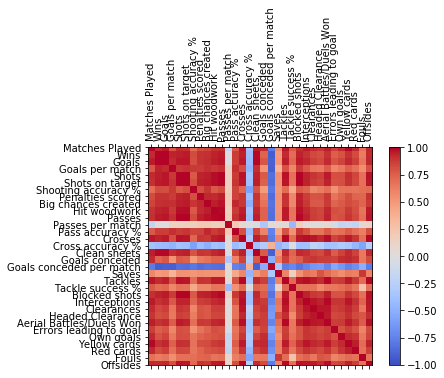

In [179]:
import matplotlib.pyplot as plt

corr = stats.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(stats.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(stats.columns)
ax.set_yticklabels(stats.columns)
plt.show()

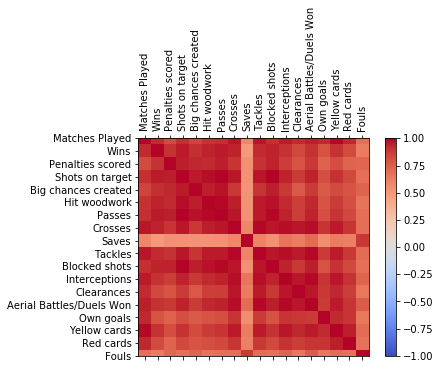

In [180]:
# Key stats

corr = key_stats.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(key_stats.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(key_stats.columns)
ax.set_yticklabels(key_stats.columns)
plt.show()

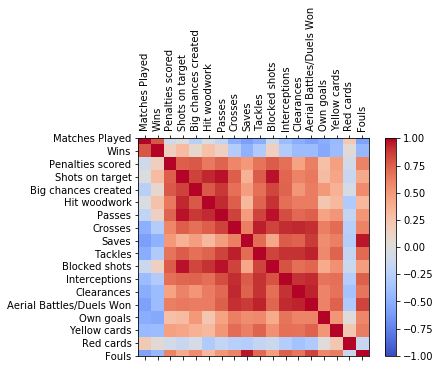

In [181]:
# Stats per match

corr = stats_per_match.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(stats_per_match.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(stats_per_match.columns)
ax.set_yticklabels(stats_per_match.columns)
plt.show()